# Soil Moisture Prediction

1. Importing Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, classification_report
import warnings
warnings.simplefilter('ignore')

2. Importing dataset

In [2]:
df = pd.read_csv('updated_sample_soil_moisture_data.csv')
df.head()

,Date,Time,Temperature (°C),Humidity (%),Soil Moisture Morning (%),Watering Done? (Y/N),Soil Moisture After X hours (%),Change in Moisture (%),Watering Needed Later? (Y/N),Time of Day
0,2025-03-28T00:00:00.000000000,09:00,29.0,73.6,19.8,Yes,22.0,2.2,Yes,Late Morning
1,2025-03-31T00:00:00.000000000,08:00,30.0,55.1,35.0,Yes,42.0,7.0,No,Late Morning
2,2025-03-25T00:00:00.000000000,08:00,21.3,88.1,52.8,Yes,59.8,7.0,No,Late Morning
3,2025-04-02T00:00:00.000000000,06:00,22.5,63.7,43.2,Yes,53.8,10.6,No,Early Morning
4,2025-04-01T00:00:00.000000000,06:00,20.4,75.7,38.9,Yes,46.3,7.4,No,Early Morning


3. Select Input & Output Features

In [4]:
# Select input features and target variables
input_features = [
    "Temperature (°C)", "Humidity (%)", "Soil Moisture Morning (%)", 
    "Watering Done? (Y/N)", "Time of Day"
]
regression_target = "Soil Moisture After X hours (%)"
classification_target = "Watering Needed Later? (Y/N)"

# Extract relevant columns
data = df[input_features]
target_regression = df[regression_target]
target_classification = df[classification_target]

4. Apply Label Encoding on categorical variables

In [5]:
# Encode categorical features
label_encoder = LabelEncoder()
data["Watering Done? (Y/N)"] = label_encoder.fit_transform(data["Watering Done? (Y/N)"])
data["Time of Day"] = label_encoder.fit_transform(data["Time of Day"])
target_classification = label_encoder.fit_transform(target_classification)

5. Apply Train Test Split separately for regression and classification data

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    data, target_regression, test_size=0.2, random_state=42
)
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    data, target_classification, test_size=0.2, random_state=42
)

6. Apply XGBoost Regressor & Evaluate it

In [70]:
import optuna
from optuna import Trial
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "subsample": trial.suggest_uniform("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.7, 1.0),
        "gamma": trial.suggest_uniform("gamma", 0, 0.2),
    }
    
    model = XGBRegressor(objective="reg:squarederror", **params)
    score = cross_val_score(model, X_train, y_train_reg, cv=3, scoring="neg_mean_squared_error").mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)

[I 2025-04-03 15:36:52,749] A new study created in memory with name: no-name-d8998ce4-5f9f-4a0c-b1df-0a3f09e1e3f8
[I 2025-04-03 15:36:53,616] Trial 0 finished with value: -5.64821623098933 and parameters: {'max_depth': 4, 'learning_rate': 0.027359128317266102, 'n_estimators': 447, 'subsample': 0.8290587266122924, 'colsample_bytree': 0.9202267306109136, 'gamma': 0.11698387804837834}. Best is trial 0 with value: -5.64821623098933.
[I 2025-04-03 15:36:54,254] Trial 1 finished with value: -11.02310030929764 and parameters: {'max_depth': 5, 'learning_rate': 0.016085810579138077, 'n_estimators': 179, 'subsample': 0.8939646109806889, 'colsample_bytree': 0.9546084396930716, 'gamma': 0.1591110761477581}. Best is trial 0 with value: -5.64821623098933.
[I 2025-04-03 15:36:54,877] Trial 2 finished with value: -6.233233207470952 and parameters: {'max_depth': 3, 'learning_rate': 0.14581145586541394, 'n_estimators': 350, 'subsample': 0.939335256035885, 'colsample_bytree': 0.9156345632337634, 'gamma':

Best hyperparameters: {'max_depth': 3, 'learning_rate': 0.02701144248087639, 'n_estimators': 248, 'subsample': 0.8243875262539391, 'colsample_bytree': 0.8035699318005508, 'gamma': 0.055618500593052234}


In [71]:
# Define the optimized model
optimized_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=0.02701144248087639,
    n_estimators=248,
    subsample=0.8243875262539391,
    colsample_bytree=0.8035699318005508,
    gamma=0.055618500593052234
)

# Train the model
optimized_model.fit(X_train, y_train_reg)

# Predict on the test set
y_pred = optimized_model.predict(X_test)

# Evaluate performance using R² Score
r2 = r2_score(y_test_reg, y_pred)
print(f"Optimized Model R² Score: {r2:.4f}")

Optimized Model R² Score: 0.9878


In [74]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Define the objective function for Bayesian Optimization
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
    }
    
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    score = cross_val_score(model, X_train, y_train_reg, cv=3, scoring="r2").mean()
    return score

# Run Bayesian Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Get the best parameters
best_rf_params = study.best_params
print("Best Random Forest Hyperparameters:", best_rf_params)

[I 2025-04-03 15:43:07,594] A new study created in memory with name: no-name-9bbfea9e-51b5-4642-bb4b-39430f23f0cd
[I 2025-04-03 15:43:10,426] Trial 0 finished with value: 0.981793569686834 and parameters: {'n_estimators': 301, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.981793569686834.
[I 2025-04-03 15:43:14,344] Trial 1 finished with value: 0.9820351973121711 and parameters: {'n_estimators': 354, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.9820351973121711.
[I 2025-04-03 15:43:16,731] Trial 2 finished with value: 0.9822789896490532 and parameters: {'n_estimators': 247, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9822789896490532.
[I 2025-04-03 15:43:20,287] Trial 3 finished with value: 0.9822107998359089 and parameters: {'n_estimators': 415, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 2 with value: 

Best Random Forest Hyperparameters: {'n_estimators': 430, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2}


In [75]:
# Train Random Forest with optimized parameters
optimized_rf = RandomForestRegressor(
    n_estimators=430,
    max_depth=7,
    min_samples_split=8,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Fit the model
optimized_rf.fit(X_train, y_train_reg)

# Predict on test data
y_pred_rf = optimized_rf.predict(X_test)

# Evaluate performance
r2_rf = r2_score(y_test_reg, y_pred_rf)
print(f"Optimized Random Forest R² Score: {r2_rf:.4f}")

Optimized Random Forest R² Score: 0.9870


In [13]:
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge

# Define base models with optimized hyperparameters
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=0.02701144248087639,
    n_estimators=248,
    subsample=0.8243875262539391,
    colsample_bytree=0.8035699318005508,
    gamma=0.055618500593052234
)

rf_model = RandomForestRegressor(
    n_estimators=430,
    max_depth=7,
    min_samples_split=8,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Define stacking model with a Ridge Regressor as meta-learner
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    final_estimator=Ridge(alpha=1.0)  # Ridge to avoid overfitting
)

# Train Stacking Model
stacking_model.fit(X_train, y_train_reg)

# Predict and Evaluate
y_pred_stack = stacking_model.predict(X_test)
r2_stack = r2_score(y_test_reg, y_pred_stack)

print(f"Stacked Model R² Score: {r2_stack:.4f}")

xgb_model.fit(X_train, y_train_reg)
rf_model.fit(X_train, y_train_reg)


y_pred_final = (0.7 * xgb_model.predict(X_test) + 
                0.3 * rf_model.predict(X_test))
print(f"Blended Model R² Score: {r2_score(y_test_reg, y_pred_final):.4f}")


Stacked Model R² Score: 0.9883
Blended Model R² Score: 0.9881


ExactExplainer explainer: 801it [03:33,  3.75it/s]                         


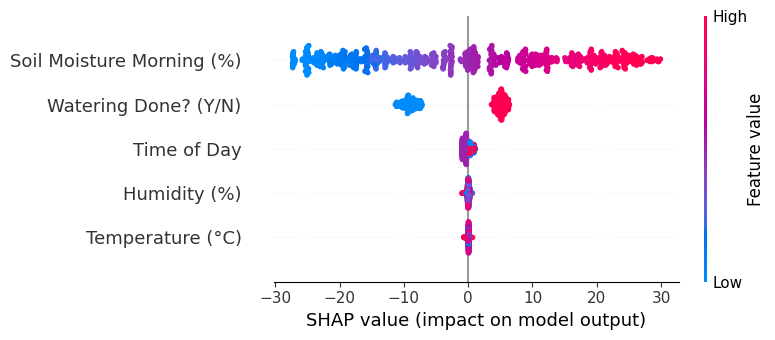

In [78]:
import shap

# Explain Stacking Model Predictions using SHAP
explainer = shap.Explainer(stacking_model.predict, X_train)
shap_values = explainer(X_train)

# Plot SHAP Summary
shap.summary_plot(shap_values, X_train)

7. Apply XGBoost Classifier & Evaluate it

In [8]:
import optuna
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "n_estimators": 100,
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train_cls, y_train_cls)
    preds = model.predict(X_test_cls)
    acc = accuracy_score(y_test_cls, preds)
    return acc

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Print best results
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2025-04-06 19:27:56,800] A new study created in memory with name: no-name-2eec3fe8-696b-48d3-b7c1-90765e433792
[I 2025-04-06 19:27:56,894] Trial 0 finished with value: 0.96 and parameters: {'max_depth': 10, 'learning_rate': 0.20095558524589147, 'subsample': 0.925343023040446, 'colsample_bytree': 0.8120868797466649, 'gamma': 4.520123320390144, 'reg_alpha': 3.062531391889136, 'reg_lambda': 4.429315262124895}. Best is trial 0 with value: 0.96.
[I 2025-04-06 19:27:56,970] Trial 1 finished with value: 0.96 and parameters: {'max_depth': 6, 'learning_rate': 0.034234730774000084, 'subsample': 0.9104092513675732, 'colsample_bytree': 0.697409623421414, 'gamma': 0.24446805873627964, 'reg_alpha': 4.570438924329963, 'reg_lambda': 3.041519189332518}. Best is trial 0 with value: 0.96.
[I 2025-04-06 19:27:57,051] Trial 2 finished with value: 0.96 and parameters: {'max_depth': 6, 'learning_rate': 0.025933397878626335, 'subsample': 0.7718628094888453, 'colsample_bytree': 0.8873185425082504, 'gamma': 

Best hyperparameters: {'max_depth': 10, 'learning_rate': 0.01819622403070504, 'subsample': 0.719736648988739, 'colsample_bytree': 0.9998552818159363, 'gamma': 4.378735029866761, 'reg_alpha': 0.0729515136503911, 'reg_lambda': 1.0065409264347664}
Best accuracy: 0.965


In [9]:
# Train the final model with the best hyperparameters
best_params = study.best_params
best_params["objective"] = "binary:logistic"
best_params["eval_metric"] = "logloss"
best_params["use_label_encoder"] = False
best_params["n_estimators"] = 100

final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train_cls, y_train_cls)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9998552818159363, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=4.378735029866761, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01819622403070504,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
# Performance of XGBClassifier
y_pred_cls = final_model.predict(X_test_cls)
cls_accuracy = accuracy_score(y_test_cls, y_pred_cls)
print(f"Classification Report:\n{classification_report(y_test_cls, y_pred_cls)}")
print(f"Classification Model Accuracy: {cls_accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       130
           1       0.97      0.93      0.95        70

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200

Classification Model Accuracy: 0.965


8. Save both the models as pickle files

In [16]:
# Saving model
import joblib

joblib.dump(xgb_model, 'reg.pkl')

['reg.pkl']

In [15]:
joblib.dump(final_model, 'cls.pkl')

['cls.pkl']